In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import time

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
metadata_indices = metadata[:, 0]["ds_slice_idx"]

# Data exploration and processing:

In [3]:
sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
sfrs = sfrs[sfrs["AVG"].notna()].copy()
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()

print("Total records (before filtering):", len(sfrs))
print("Total records (after filtering AVG >= -80):", len(sfrs_filtered))
print("FLAG == 0 count:", len(sfrs_flag0_filtered))

mask_all = np.in1d(metadata_indices, sfrs_filtered.index)
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)
selected_all = metadata_indices[mask_all]
selected_flag0 = metadata_indices[mask_flag0]

Total records (before filtering): 34613
Total records (after filtering AVG >= -80): 30752
FLAG == 0 count: 16841


In [4]:
all_images = []
all_spectra = []
filtered_images = []
filtered_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask_all]
        spectra_zoom = cube[spec_key][:][mask_all]
    all_images.append(images_zoom)
    all_spectra.append(spectra_zoom)
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom_flag0 = cube[img_key][:][mask_flag0]
        spectra_zoom_flag0 = cube[spec_key][:][mask_flag0]
    filtered_images.append(images_zoom_flag0)
    filtered_spectra.append(spectra_zoom_flag0)

print("All images shape (zoom 0):", all_images[0].shape)
print("Filtered images shape (zoom 0):", filtered_images[0].shape)
print("All spectra shape (zoom 0):", all_spectra[0].shape)
print("Filtered spectra shape (zoom 0):", filtered_spectra[0].shape)

All images shape (zoom 0): (30752, 5, 64, 64)
Filtered images shape (zoom 0): (16841, 5, 64, 64)
All spectra shape (zoom 0): (30752, 4620)
Filtered spectra shape (zoom 0): (16841, 4620)


In [5]:
mask_clean_all = ~np.isnan(all_spectra[0]).any(axis=1)
mask_clean_flag0 = ~np.isnan(filtered_spectra[0]).any(axis=1)

cleaned_all_images = [arr[mask_clean_all] for arr in all_images]
cleaned_all_spectra = [arr[mask_clean_all] for arr in all_spectra]
cleaned_filtered_images = [arr[mask_clean_flag0] for arr in filtered_images]
cleaned_filtered_spectra = [arr[mask_clean_flag0] for arr in filtered_spectra]

selected_all_clean = selected_all[mask_clean_all]
selected_flag0_clean = selected_flag0[mask_clean_flag0]

cleaned_sfrs_all = sfrs_filtered.loc[selected_all_clean]
cleaned_sfrs_flag0 = sfrs_flag0_filtered.loc[selected_flag0_clean]

print("Cleaned All spectra shape (zoom 0):", cleaned_all_spectra[0].shape)
print("Cleaned FLAG==0 spectra shape (zoom 0):", cleaned_filtered_spectra[0].shape)

Cleaned All spectra shape (zoom 0): (20157, 4620)
Cleaned FLAG==0 spectra shape (zoom 0): (11179, 4620)


In [6]:
def normalize_images(images_list):
    normalized_list = []
    for img_array in images_list:
        min_val = np.min(img_array, axis=(2,3), keepdims=True)
        max_val = np.max(img_array, axis=(2,3), keepdims=True)
        norm_img = 2 * (img_array - min_val) / (max_val - min_val) - 1
        normalized_list.append(norm_img)
    return normalized_list

normalized_all_images = normalize_images(cleaned_all_images)
normalized_filtered_images = normalize_images(cleaned_filtered_images)

def normalize_spectra(spectra_list):
    normalized_list = []
    for spec in spectra_list:
        if spec.ndim == 1:
            spec = spec[np.newaxis, :]
        min_val = np.nanmin(spec, axis=1, keepdims=True)
        max_val = np.nanmax(spec, axis=1, keepdims=True)
        diff = np.where((max_val - min_val)==0, 1, max_val - min_val)
        norm_spec = 2 * (spec - min_val) / diff - 1
        normalized_list.append(norm_spec)
    return normalized_list

normalized_all_spectra = normalize_spectra(cleaned_all_spectra)
normalized_filtered_spectra = normalize_spectra(cleaned_filtered_spectra)

FLAG == 0 (Original): Found 1111 images with multiple objects from 11179 (9.94%).


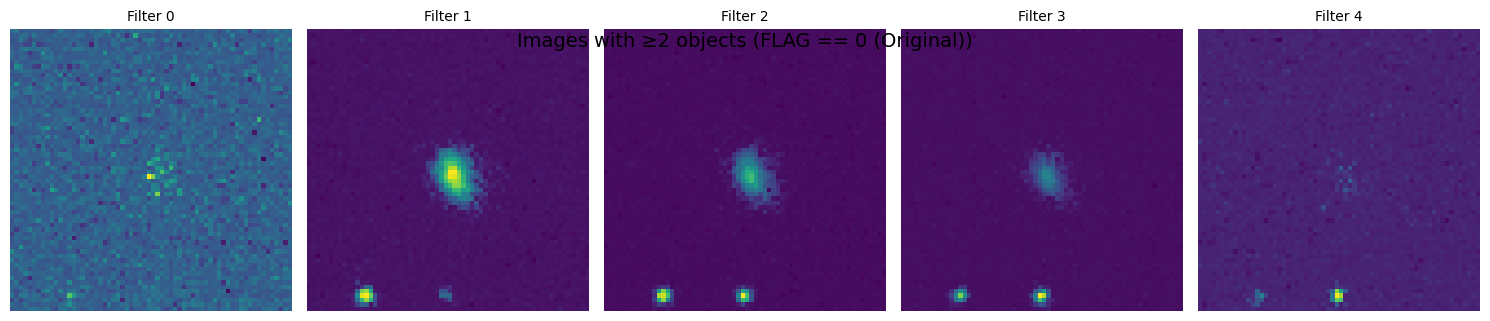

In [7]:
selected_Y_flag0 = cleaned_sfrs_flag0.loc[selected_flag0_clean]["AVG"].values

CROP_SIZES_4 = {0: 32, 1: 16, 2: 8, 3: 4} 
THRESHOLD = 0.9

def detect_and_visualize_multiple_objects(images_list, thresholds, crop_sizes=None, max_objects=1, thumbnail_size=3, group_name="", print_spectra=False, spectra_list=None):
    images_trimmed = []
    for i, img_array in enumerate(images_list):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        images_trimmed.append(trimmed)
    multi_obj_indices = []
    for idx in range(images_trimmed[0].shape[0]):
        image = images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    total_images = images_trimmed[0].shape[0]
    count_multi = len(multi_obj_indices)
    percent_multi = (count_multi / total_images)*100 if total_images>0 else 0
    print(f"{group_name}: Found {count_multi} images with multiple objects from {total_images} ({percent_multi:.2f}%).")
    if multi_obj_indices:
        display_indices = multi_obj_indices[:max_objects]
        if print_spectra and spectra_list is not None:
            num_disp = len(display_indices)
            fig = plt.figure(figsize=(15, thumbnail_size * 2 * num_disp), dpi=100)
            gs = gridspec.GridSpec(2 * num_disp, 5, hspace=0.6, wspace=0.3)
            for i, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = fig.add_subplot(gs[2*i, col])
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
                ax_spec = fig.add_subplot(gs[2*i+1, :])
                spectrum = spectra_list[0][obj_idx]
                wavelengths = np.linspace(3800,9200, len(spectrum))
                ax_spec.plot(wavelengths, spectrum, linewidth=0.3)
                ax_spec.set_title("Spectrum (Zoom 0)", fontsize=10)
                ax_spec.set_xlabel("Wavelength (Å)", fontsize=10)
                ax_spec.set_ylabel("Flux", fontsize=10)
                ax_spec.set_xlim([3800,9200])
                ax_spec.set_ylim([-1,1])
            fig.suptitle(f"Images with ≥2 objects and spectra ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.93)
            plt.show()
        else:
            num_disp = len(display_indices)
            fig, axes = plt.subplots(num_disp, 5, figsize=(15, thumbnail_size * num_disp), dpi=100)
            if num_disp == 1:
                axes = axes.reshape(1, -1)
            for row, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = axes[row, col]
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
            fig.suptitle(f"Images with ≥2 objects ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.99)
            plt.show()
    else:
        print(f"No images found for {group_name} with multiple objects.")
    return images_trimmed, multi_obj_indices

orig_images_flag0, multi_obj_indices_flag0 = detect_and_visualize_multiple_objects(
    normalized_filtered_images, thresholds=THRESHOLD, crop_sizes=None,
    group_name="FLAG == 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra
)

In [8]:
X_photo_all = orig_images_flag0[0]        
X_spec_all = normalized_filtered_spectra[0]  
mask_good = np.ones(X_photo_all.shape[0], dtype=bool)
mask_good[multi_obj_indices_flag0] = False

X_photo = X_photo_all[mask_good]
X_spec = X_spec_all[mask_good]
Y = selected_Y_flag0[:X_photo_all.shape[0]][mask_good]

n_samples = min(X_photo.shape[0], X_spec.shape[0], len(Y))
X_photo = X_photo[:n_samples]
X_spec = X_spec[:n_samples]
Y = Y[:n_samples]

In [9]:
X_photo_train_val, X_photo_test, X_spec_train_val, X_spec_test, Y_train_val, Y_test = train_test_split(
    X_photo, X_spec, Y, test_size=0.2, random_state=42
)
X_photo_train, X_photo_val, X_spec_train, X_spec_val, Y_train, Y_val = train_test_split(
    X_photo_train_val, X_spec_train_val, Y_train_val, test_size=0.25, random_state=42
)

print("Train samples:", X_photo_train.shape[0])
print("Validation samples:", X_photo_val.shape[0])
print("Test samples:", X_photo_test.shape[0])

Train samples: 6040
Validation samples: 2014
Test samples: 2014


# Machine Learning (FLAG == 0 only):

## Decision tree:

In [10]:
def run_grid_search_dt(X, Y, param_grid):
    X_flat = X.reshape(X.shape[0], -1)
    model = DecisionTreeRegressor(random_state=42)
    grid = GridSearchCV(model, param_grid, scoring='r2', cv=5)
    grid.fit(X_flat, Y)
    best_model = grid.best_estimator_
    return best_model, grid.best_params_, grid.best_score_


def evaluate_model(model, X, Y):
    X_flat = X.reshape(X.shape[0], -1)
    Y_pred = model.predict(X_flat)
    mae = mean_absolute_error(Y, Y_pred)
    r2 = r2_score(Y, Y_pred)
    error = Y_pred - Y
    nmad = 1.4826 * np.median(np.abs(error - np.median(error)))
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))
    return mae, r2, nmad, rmse

def flatten_data(X):
    return X.reshape(X.shape[0], -1)

param_grid_dt = {
    'max_depth': [10, 15],
    'max_features': ['sqrt', None]
}

results = {}
runtime = {}

## Spectrum and Photo separately:

### DT on Photo: 

In [11]:
start = time.time()
model_photo, params_photo, cv_score_photo = run_grid_search_dt(X_photo_train, Y_train, param_grid_dt)
runtime["DT Photo"] = time.time() - start

mae_photo_val, r2_photo_val, nmad_photo_val, rmse_photo_val = evaluate_model(model_photo, X_photo_val, Y_val)
results["DT Photo"] = {
    'params': params_photo,
    'cv_score': cv_score_photo,
    'mae': mae_photo_val,
    'r2': r2_photo_val,
    'nmad': nmad_photo_val,
    'rmse': rmse_photo_val
}
print("DT Photo best params:", params_photo)

DT Photo best params: {'max_depth': 10, 'max_features': 'sqrt'}


### DT on Spectra:

In [12]:
start = time.time()
model_spec, params_spec, cv_score_spec = run_grid_search_dt(X_spec_train, Y_train, param_grid_dt)
runtime["DT Spectra"] = time.time() - start

mae_spec_val, r2_spec_val, nmad_spec_val, rmse_spec_val = evaluate_model(model_spec, X_spec_val, Y_val)
results["DT Spectra"] = {
    'params': params_spec,
    'cv_score': cv_score_spec,
    'mae': mae_spec_val,
    'r2': r2_spec_val,
    'nmad': nmad_spec_val,
    'rmse': rmse_spec_val
}
print("DT Spectra best params:", params_spec)

DT Spectra best params: {'max_depth': 10, 'max_features': 'sqrt'}


### DT Early Fusion:

In [13]:
X_photo_train_flat = flatten_data(X_photo_train)
X_spec_train_flat = flatten_data(X_spec_train)
X_early_train = np.concatenate([X_photo_train_flat, X_spec_train_flat], axis=1)

X_photo_val_flat = flatten_data(X_photo_val)
X_spec_val_flat = flatten_data(X_spec_val)
X_early_val = np.concatenate([X_photo_val_flat, X_spec_val_flat], axis=1)

start = time.time()
model_early, params_early, cv_score_early = run_grid_search_dt(X_early_train, Y_train, param_grid_dt)
runtime["DT Early Fusion"] = time.time() - start

mae_early_val, r2_early_val, nmad_early_val, rmse_early_val = evaluate_model(model_early, X_early_val, Y_val)
results["DT Early Fusion"] = {
    'params': params_early,
    'cv_score': cv_score_early,
    'mae': mae_early_val,
    'r2': r2_early_val,
    'nmad': nmad_early_val,
    'rmse': rmse_early_val
}
print("DT Early Fusion best params:", params_early)

DT Early Fusion best params: {'max_depth': 10, 'max_features': 'sqrt'}


### DT Late Fusion:

In [14]:
Y_pred_dt_photo_test = model_photo.predict(flatten_data(X_photo_test))
Y_pred_dt_spec_test = model_spec.predict(flatten_data(X_spec_test))
Y_pred_dt_late_test = (Y_pred_dt_photo_test + Y_pred_dt_spec_test) / 2.0

X_photo_test_flat = flatten_data(X_photo_test)
X_spec_test_flat = flatten_data(X_spec_test)
X_early_test = np.concatenate([X_photo_test_flat, X_spec_test_flat], axis=1)
Y_pred_dt_early_test = model_early.predict(X_early_test)

runtime["DT Late Fusion"] = runtime["DT Photo"] + runtime["DT Spectra"]

### Compile all results:

In [15]:
Y_pred_photo_test = model_photo.predict(flatten_data(X_photo_test))
mae_photo_test  = mean_absolute_error(Y_test, Y_pred_photo_test)
r2_photo_test   = r2_score(Y_test, Y_pred_photo_test)
error_photo_test = Y_pred_photo_test - Y_test
nmad_photo_test = 1.4826 * np.median(np.abs(error_photo_test - np.median(error_photo_test)))
rmse_photo_test = np.sqrt(mean_squared_error(Y_test, Y_pred_photo_test))

Y_pred_spec_test = model_spec.predict(flatten_data(X_spec_test))
mae_spec_test  = mean_absolute_error(Y_test, Y_pred_spec_test)
r2_spec_test   = r2_score(Y_test, Y_pred_spec_test)
error_spec_test = Y_pred_spec_test - Y_test
nmad_spec_test = 1.4826 * np.median(np.abs(error_spec_test - np.median(error_spec_test)))
rmse_spec_test = np.sqrt(mean_squared_error(Y_test, Y_pred_spec_test))

X_photo_test_flat = flatten_data(X_photo_test)
X_spec_test_flat  = flatten_data(X_spec_test)
X_early_test      = np.concatenate([X_photo_test_flat, X_spec_test_flat], axis=1)
Y_pred_early_test = model_early.predict(X_early_test)
mae_early_test  = mean_absolute_error(Y_test, Y_pred_early_test)
r2_early_test   = r2_score(Y_test, Y_pred_early_test)
error_early_test = Y_pred_early_test - Y_test
nmad_early_test = 1.4826 * np.median(np.abs(error_early_test - np.median(error_early_test)))
rmse_early_test = np.sqrt(mean_squared_error(Y_test, Y_pred_early_test))

Y_pred_late_test = (Y_pred_photo_test + Y_pred_spec_test) / 2.0
mae_late_test  = mean_absolute_error(Y_test, Y_pred_late_test)
r2_late_test   = r2_score(Y_test, Y_pred_late_test)
error_late_test = Y_pred_late_test - Y_test
nmad_late_test = 1.4826 * np.median(np.abs(error_late_test - np.median(error_late_test)))
rmse_late_test = np.sqrt(mean_squared_error(Y_test, Y_pred_late_test))

results_test = {
    "DT Photo":   {'r2': r2_photo_test,   'mae': mae_photo_test,   'nmad': nmad_photo_test,   'rmse': rmse_photo_test},
    "DT Spectra": {'r2': r2_spec_test,    'mae': mae_spec_test,    'nmad': nmad_spec_test,    'rmse': rmse_spec_test},
    "DT Early Fusion": {'r2': r2_early_test, 'mae': mae_early_test, 'nmad': nmad_early_test, 'rmse': rmse_early_test},
    "DT Late Fusion":  {'r2': r2_late_test,  'mae': mae_late_test,  'nmad': nmad_late_test,  'rmse': rmse_late_test}
}

### Visualization of comparative metrics:

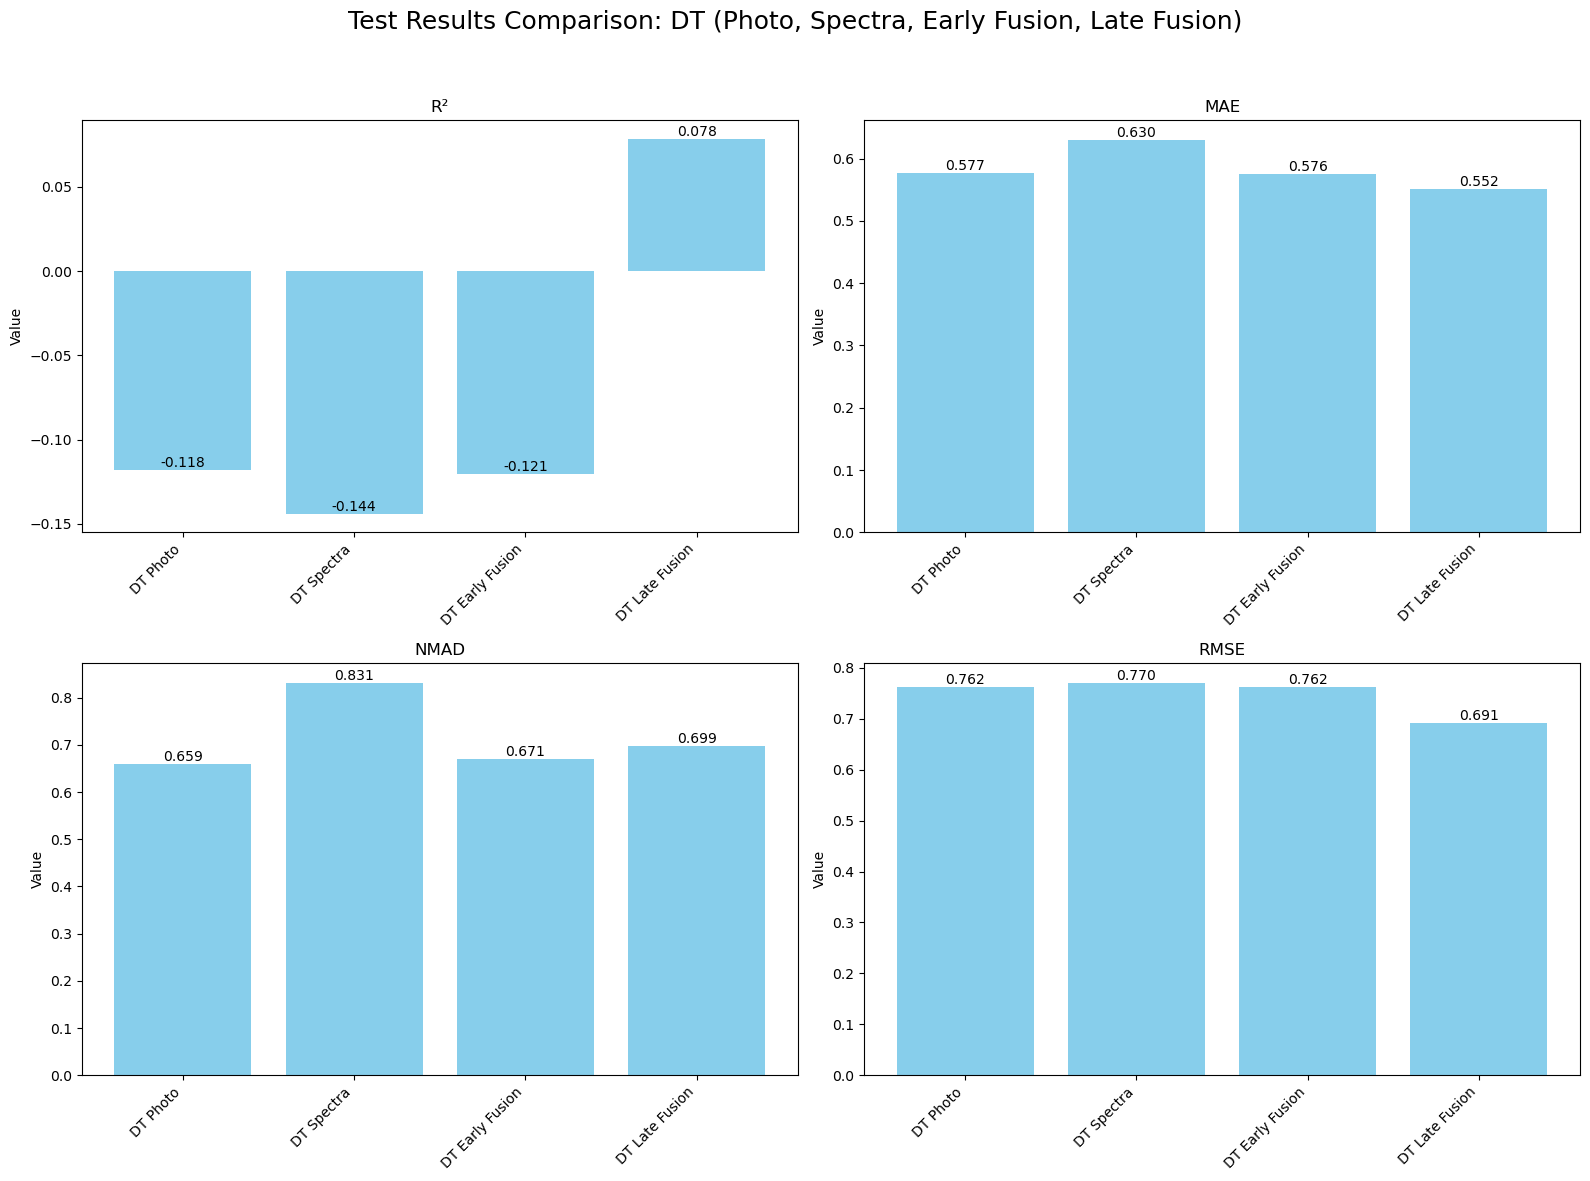

In [16]:
methods = list(results_test.keys())
metrics_names = ['R²', 'MAE', 'NMAD', 'RMSE']
values = {metric: [] for metric in metrics_names}
for method in methods:
    values['R²'].append(results_test[method].get('r2', 0))
    values['MAE'].append(results_test[method].get('mae', 0))
    values['NMAD'].append(results_test[method].get('nmad', 0))
    values['RMSE'].append(results_test[method].get('rmse', 0))

x = np.arange(len(methods))
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()
for i, metric in enumerate(metrics_names):
    axs[i].bar(x, values[metric], color='skyblue')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(methods, rotation=45, ha='right')
    axs[i].set_title(metric)
    axs[i].set_ylabel("Value")
    for j, v in enumerate(values[metric]):
        axs[i].text(j, v, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.suptitle("Test Results Comparison: DT (Photo, Spectra, Early Fusion, Late Fusion)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Visualization of runtimes:

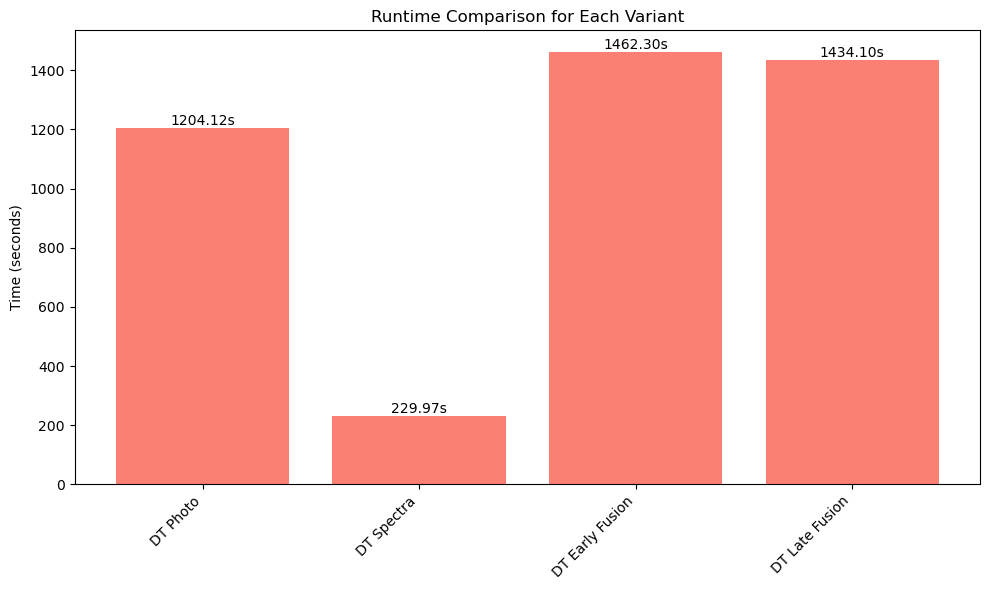

In [17]:
runtime_methods = list(runtime.keys())
runtime_values = [runtime[m] for m in runtime_methods]

plt.figure(figsize=(10, 6))
plt.bar(runtime_methods, runtime_values, color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Time (seconds)")
plt.title("Runtime Comparison for Each Variant")
for i, t in enumerate(runtime_values):
    plt.text(i, t, f"{t:.2f}s", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()